# SHRED-ROM Tutorial on Kuramoto Sivashinsky

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eFR-3l6qFgo3360V2LrJqBPSLheI4Mfd)

#### Import Libraries

In [19]:
# PYSHRED
%load_ext autoreload
%autoreload 2
from pyshred import ParametricDataManager, SHRED, ParametricSHREDEngine

# Other helper libraries
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Kuramoto Sivashinsky dataset

In [20]:
import numpy as np
import urllib.request
# URL of the NPZ file
url = 'https://zenodo.org/records/14524524/files/KuramotoSivashinsky_data.npz?download=1'
# Local filename to save the downloaded file
filename = 'KuramotoSivashinsky_data.npz'
# Download the file from the URL
urllib.request.urlretrieve(url, filename)
# Load the data from the NPZ file
dataset = np.load(filename)

#### Initialize Data Manager

In [21]:
# Initialize ParametricSHREDDataManager
manager = ParametricDataManager(
    lags = 20,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

#### Add datasets and sensors

In [22]:
data = dataset['u'] # shape (500, 201, 100)

manager.add_data(
    data=data,
    random=3,
    # stationary=[(15,),(30,),(45,)],
    id = 'KS',
    compress = False
)

#### Analyze sensor summary

In [23]:
manager.sensor_measurements_df

,KS-0,KS-1,KS-2
0,0.047727,0.553612,-0.954329
1,0.067329,0.695523,-0.849845
2,0.014021,0.630202,-0.823280
3,-0.031031,0.515125,-0.789117
4,-0.063776,0.346338,-0.763155
...,...,...,...
100495,-0.039383,1.815631,-1.450543
100496,-0.029805,1.404686,-0.953344
100497,-0.026611,0.981305,-0.544849
100498,-0.030562,0.600680,-0.249002


In [24]:
manager.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,KS,0,stationary (random),"(52,)"
1,KS,1,stationary (random),"(76,)"
2,KS,2,stationary (random),"(32,)"


#### Get train, validation, and test set

In [25]:
train_dataset, val_dataset, test_dataset= manager.prepare()

#### Initialize SHRED

When using a `ParametricDataManager`, ensure `latent_forecaster` is set to None.

In [26]:
shred = SHRED(sequence_model="LSTM", decoder_model="MLP", latent_forecaster=None)

#### Fit SHRED

In [27]:
val_errors = shred.fit(train_dataset=train_dataset, val_dataset=val_dataset, num_epochs=20, sindy_regularization=0)
print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.029015
Validation MSE (epoch 1): 0.021528
Epoch 2: Average training loss = 0.013127
Validation MSE (epoch 2): 0.014481
Epoch 3: Average training loss = 0.009712
Validation MSE (epoch 3): 0.010857
Epoch 4: Average training loss = 0.008075
Validation MSE (epoch 4): 0.009062
Epoch 5: Average training loss = 0.006994
Validation MSE (epoch 5): 0.008068
Epoch 6: Average training loss = 0.006186
Validation MSE (epoch 6): 0.007633
Epoch 7: Average training loss = 0.005487
Validation MSE (epoch 7): 0.006828
Epoch 8: Average training loss = 0.004934
Validation MSE (epoch 8): 0.005742
Epoch 9: Average training loss = 0.004453
Validation MSE (epoch 9): 0.005338
Epoch 10: Average training loss = 0.004108
Validation MSE (epoch 10): 0.005088
Epoch 11: Average training loss = 0.003822
Validation MSE (epoch 11): 0.004542
Epoch 12: Average training loss = 0.003573
Validation MSE (epoch 12): 0.004109
Epoch 13: Average training loss = 0.003342
Validation

#### Evaluate SHRED

In [28]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.002
Val   MSE: 0.003
Test  MSE: 0.002


#### Initialize Parametric SHRED Engine for Downstream Tasks

In [29]:
engine = ParametricSHREDEngine(manager, shred)

#### Sensor Measurements to Latent Space

In [30]:
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

#### Decode Latent Space to Full-State Space

In [31]:
test_prediction = engine.decode(test_latent_from_sensors) # latent space generated from sensor data

#### Compare prediction against the truth

Since both number of trajectories (`data.shape[0]`) and number of timesteps (`data.shape[1]`) are both variable, we will leave them combined on the first axis. The remaining axes are all spatial dimensions.

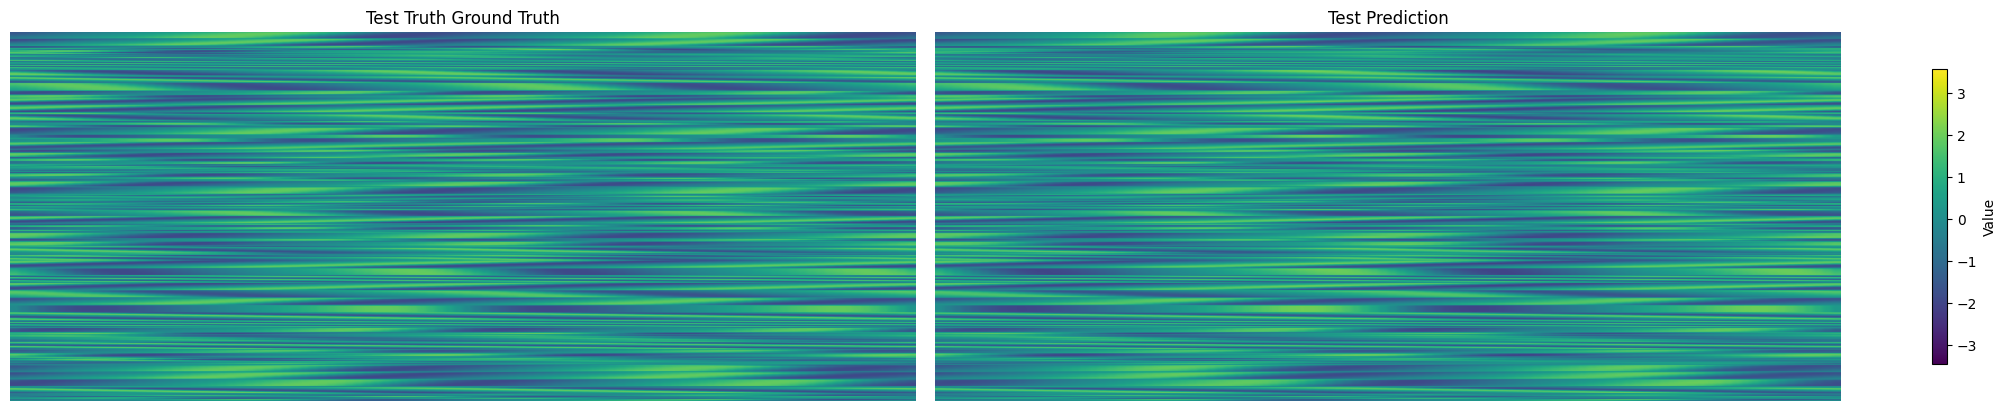

In [32]:
spatial_shape = data.shape[2:]
test_data = data[manager.test_indices]
truth      = test_data.reshape(-1, *spatial_shape)
prediction = test_prediction['KS']

compare_data = [truth, prediction]
titles = ["Test Truth Ground Truth", "Test Prediction"]

vmin, vmax = np.min([d.min() for d in compare_data]), np.max([d.max() for d in compare_data])

fig, axes = plt.subplots(1, 2, figsize=(20, 4), constrained_layout=True)

for ax, d, title in zip(axes, compare_data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax, aspect='auto')
    ax.set(title=title)
    ax.axis("off")

fig.colorbar(im, ax=axes, label="Value", shrink=0.8)

#### Evaluate MSE on Ground Truth Data

Since both number of trajectories (`data.shape[0]`) and number of timesteps (`data.shape[1]`) are both variable, we will leave them combined on the first axis. The remaining axes are all spatial dimensions.

In [33]:
# Train
t_train = len(manager.train_sensor_measurements)
train_Y = {'KS': data[0:t_train].reshape(-1, *spatial_shape)} # unpack the spatial dimensions
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# Val
t_val = len(manager.test_sensor_measurements)
val_Y = {'KS': data[t_train:t_train+t_val].reshape(-1, *spatial_shape)}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# Test
t_test = len(manager.test_sensor_measurements)
test_Y = {'KS': data[-t_test:].reshape(-1, *spatial_shape)}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

print('---------- TRAIN ----------')
print(train_error)
print('\n---------- VAL   ----------')
print(val_error)
print('\n---------- TEST  ----------')
print(test_error)

---------- TRAIN ----------
              MSE      RMSE       MAE       R2
dataset                                       
KS       0.058591  0.242056  0.157245  0.95542

---------- VAL   ----------
              MSE      RMSE      MAE        R2
dataset                                       
KS       0.108668  0.329648  0.20142  0.916482

---------- TEST  ----------
              MSE      RMSE       MAE        R2
dataset                                        
KS       0.073058  0.270293  0.160392  0.944935
